In [ ]:
pip install openai

In [2]:
import re
import pandas as pd
import openai
from openai import OpenAI
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from google.colab import drive
import time
from google.colab import userdata
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/drive')
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/NLP/downsampled_data.csv",
    usecols=["Score", "Text"]
)
# split on the five star score, not on sentiment so after changing from 5 label to 3 label the distribution is 40-20-40
train_df, test_df = train_test_split(
        df,
        test_size=0.1,
        stratify=df['Score'],
        random_state=42
    )
def to_three(x):
  if x <= 2: return 1      # 1–2 stars → class 1
  if x == 3: return 2      # 3 stars   → class 2
  return 3                 # 4–5 stars → class 3
test_df["Score"] = test_df["Score"].apply(to_three)
print(test_df.head())
print(test_df.tail())

Mounted at /content/drive
      Score                                               Text
2260      1  Of the 18 bars I got, five or six had dead spi...
4692      2  It seems that this Yumberry Blackcurrat tea ma...
2333      1  I bought the pears thinking they would be a go...
7134      3  I use Head and Shoulders b/c I have moderate d...
241       1  These taste like old canned peas with very lit...
      Score                                               Text
40        1  I am looking for rawhide bones such as these m...
5817      2  I have been using Splenda for a while and now ...
8839      3  These belts are so good! I am eating one as I ...
2300      1  I eat mixed nuts all the time at work. They ma...
4929      2  My cats enjoy inclined ramps to scratch, and i...


In [ ]:
len(test_df)

1000

In [ ]:
client = OpenAI(
  api_key=userdata.get('OPENAI_API')
)
MODEL  = "gpt-4o-mini"

In [ ]:
# try adding system message

def predict_rating(review: str) -> int:
    # prompt = f"Given the following Amazon review, predict the star rating of the review on a scale of 1-5. Answer only with a signle integer from 1 to 5: {review}"
    prompt = f"Given the following Amazon review, predict the sentiment score of the review. Respond with only a single integer: 1 for negative, 2 for neutral, or 3 for positive. Review: {review}"
    messages = [{"role": "user", "content": prompt}]
    resp = client.chat.completions.create(model=MODEL, messages=messages)
    # extract the first choice’s content
    out = resp.choices[0].message.content.strip()
    # make sure the answer only includes one integer
    m = re.findall(r"[1-3]", out)
    if len(m) == 0:
        raise ValueError(f"No rating found in model output: {out!r}")
    if len(m) > 1:
        raise ValueError(f"Multiple ratings found in model output: {out!r}")
    return int(m[0])

preds = []
for i, txt in enumerate(test_df["Text"]):
    preds.append(predict_rating(txt))
    if (i + 1) % 100 == 0:
        print(f"→ done {i+1} reviews")

test_df["pred"] = preds

y_true = test_df["Score"]
y_pred = test_df["pred"]



→ done 100 reviews
→ done 200 reviews
→ done 300 reviews
→ done 400 reviews
→ done 500 reviews
→ done 600 reviews
→ done 700 reviews
→ done 800 reviews
→ done 900 reviews
→ done 1000 reviews


In [ ]:
print("Model:", "LLM with 3 label (1000 samples)")
print("Accuracy: ",  accuracy_score( y_true, y_pred ))
print("Precision:", precision_score(y_true, y_pred, average="macro", zero_division=0))
print("F1 score:",  f1_score(    y_true, y_pred, average="macro", zero_division=0))
print("\nFull classification report:\n")
print(classification_report(y_true, y_pred, digits=3))

Model: LLM with 3 label (1000 samples)
Accuracy:  0.792
Precision: 0.7657805852747942
F1 score: 0.7636063895076314

Full classification report:

              precision    recall  f1-score   support

           1      0.858     0.787     0.821       400
           2      0.502     0.670     0.574       200
           3      0.937     0.858     0.896       400

    accuracy                          0.792      1000
   macro avg      0.766     0.772     0.764      1000
weighted avg      0.819     0.792     0.802      1000



In [ ]:
print("Model:", "LLM with 3 label ")
print("Accuracy: ",  accuracy_score( y_true, y_pred ))
print("Precision:", precision_score(y_true, y_pred, average="macro", zero_division=0))
print("F1 score:",  f1_score(    y_true, y_pred, average="macro", zero_division=0))
print("\nFull classification report:\n")
print(classification_report(y_true, y_pred, digits=3))

Model: LLM with 3 label
Accuracy:  0.791
Precision: 0.7628455774060671
F1 score: 0.7611724413951758

Full classification report:

              precision    recall  f1-score   support

           1      0.865     0.804     0.833      4000
           2      0.500     0.654     0.567      2000
           3      0.924     0.846     0.883      4000

    accuracy                          0.791     10000
   macro avg      0.763     0.768     0.761     10000
weighted avg      0.815     0.791     0.800     10000



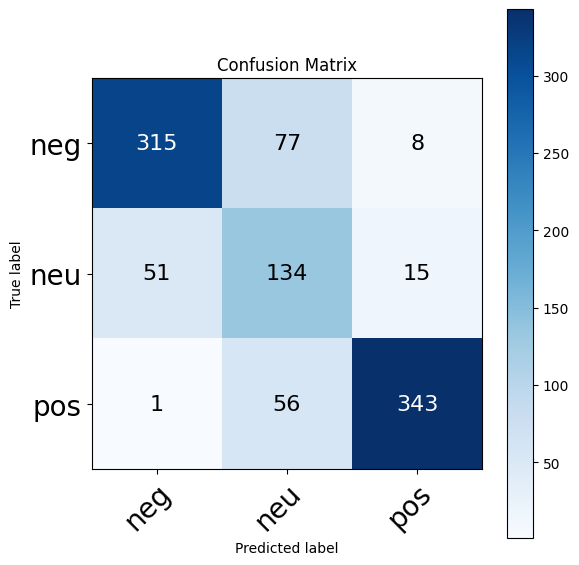

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')  # white→blue
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(3),
    yticks=np.arange(3),
    xticklabels=['neg', 'neu', 'pos'],
    yticklabels=['neg', 'neu', 'pos'],
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix",
)
ax.set_xticklabels(['neg', 'neu', 'pos'], fontsize=20)
ax.set_yticklabels(['neg', 'neu', 'pos'], fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotate counts in the matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                size = 16)

plt.tight_layout()
plt.show()

In [ ]:
df.head(100)

,Score,Text,pred
0,1,I purchased this for the health benefits. Unf...,1
1,1,"I like the taste of this dressing, but realize...",1
2,1,Drink tasted like water...no chocolate taste a...,1
3,1,This tastes very sweet compared to other brand...,1
4,1,I ordered 3 jars of this calorie free Alfredo ...,1
...,...,...,...
95,1,made a pot of this coffee and none of our gues...,1
96,1,"Note-- look closely, it's ""Toddler Formula"" an...",2
97,1,"I was so excited when I bought this toy, imagi...",2
98,1,I bought the 35 count variety pack thinking it...,1


In [ ]:
df.tail(10)

,Score,Text,pred
9990,3,Mix this up with some vanilla yogurt and Cool ...,3
9991,3,This is the best almond butter on the market. ...,3
9992,3,I'm usually very particular in what I use trea...,3
9993,3,My kids and all their friends LOVE these as a ...,3
9994,3,These are our favorite kind of cookies! Usuall...,3
9995,3,This is the best way to cook a roast. Our loc...,3
9996,3,"Excellent product, slightly different than any...",3
9997,3,My wife and I enjoy a pot of Green Chai Tea ea...,3
9998,3,Our Yorkie loves this stuff. Our vet gave her ...,3
9999,3,I've been on the auto ship with this item for ...,3
